In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("C:\\Users\\NT551_11TH\\Documents\\Streak_Breaking_Solution\\data")
paths = {"pre": BASE / "pre.csv", "streak": BASE / "streak.csv", "post": BASE / "post.csv"}

def read_csv_try(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    try:
        try:
            df = pd.read_csv(path)
        except UnicodeDecodeError:
            df = pd.read_csv(path, encoding="cp949")
    except Exception as e:
        raise RuntimeError(f"Failed to read {path.name}: {e}")
    df.columns = [c.strip() for c in df.columns]
    return df

pre    = read_csv_try(paths["pre"])
streak = read_csv_try(paths["streak"])
post   = read_csv_try(paths["post"])

# segment 라벨 보정
if "segment" not in pre.columns:    pre["segment"] = "pre"
if "segment" not in streak.columns: streak["segment"] = "streak"
if "segment" not in post.columns:   post["segment"] = "post"

# -------- 유틸 --------
def pick_col(df: pd.DataFrame, candidates):
    lowmap = {c.lower(): c for c in df.columns}
    for name in candidates:
        k = name.lower()
        if k in lowmap:
            return lowmap[k]
    return None

def safe_div(a, b):
    a = np.asarray(a, dtype="float64")
    b = np.asarray(b, dtype="float64")
    return np.where(np.abs(b) < 1e-12, np.nan, a / b)

# -------- 파생지표(도루 지표 제거) + BaseRuns 추가 --------
def add_derived(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # 필드 추출(없으면 0)
    def get_num(cands):
        col = pick_col(out, cands)
        if col is None:
            return pd.Series(0.0, index=out.index, dtype="float64")
        return pd.to_numeric(out[col], errors="coerce").fillna(0.0)

    AB  = get_num(["AB","타수"])
    H   = get_num(["H","안타"])
    _2B = get_num(["2B","2루타"])
    _3B = get_num(["3B","3루타","삼루타"])
    HR  = get_num(["HR","홈런"])
    BB  = get_num(["BB","볼넷"])
    HBP = get_num(["HBP","사구"])
    SF  = get_num(["SF","희생플라이"])
    SO  = get_num(["SO","삼진"])

    # TB 계산
    TB_col = pick_col(out, ["TB","총루타","루타"])
    SLG_col = pick_col(out, ["SLG"])
    AVG_col = pick_col(out, ["AVG"])
    OBP_col = pick_col(out, ["OBP"])
    OPS_col = pick_col(out, ["OPS"])

    if TB_col:
        TB = pd.to_numeric(out[TB_col], errors="coerce").fillna(0.0)
    else:
        if SLG_col:
            SLG_vals = pd.to_numeric(out[SLG_col], errors="coerce").fillna(0.0)
            TB = SLG_vals * AB
        else:
            single = (H - _2B - _3B - HR).clip(lower=0)
            TB = single + 2*_2B + 3*_3B + 4*HR

    # AVG / SLG / OBP / OPS
    if AVG_col: AVG = pd.to_numeric(out[AVG_col], errors="coerce")
    else:       AVG = safe_div(H, AB)

    if SLG_col: SLG = pd.to_numeric(out[SLG_col], errors="coerce")
    else:       SLG = safe_div(TB, AB)

    if OBP_col:
        OBP = pd.to_numeric(out[OBP_col], errors="coerce")
    else:
        denom = AB + BB + HBP + SF
        OBP = safe_div(H + BB + HBP, denom)

    if OPS_col:
        OPS = pd.to_numeric(out[OPS_col], errors="coerce")
    else:
        OPS = OBP + SLG

    # ISO, DER, KBB
    out["ISO"] = SLG - AVG
    DER = safe_div((AB - H - HR), (AB - HR - SO))
    out["DER"] = pd.Series(DER, index=out.index).clip(0, 1)  # [0,1] 클립
    out["KBB"] = pd.Series(safe_div(SO, BB), index=out.index)

    # BaseRuns (브라운/스미스 계열 근사)
    # A = H + BB + HBP - HR
    # B = 1.4*TB - 0.6*H - 3*HR + 0.1*(BB + HBP)
    # C = AB - H   (아웃카운트 없음 → 근사)
    # D = HR
    # exp_runs = (A*B)/(B+C) + D   (B+C<=0 → NaN)
    A = H + BB + HBP - HR
    B = 1.4*TB - 0.6*H - 3*HR + 0.1*(BB + HBP)
    C = AB - H
    D = HR
    exp_runs = np.where((B + C) <= 0, np.nan, (A * B) / (B + C) + D)
    out["exp_runs"] = exp_runs

    # 실제 득점 컬럼 자동 탐지
    R_col = pick_col(out, ["R","runs","득점","RS","score","RBI"])
    actual_runs = pd.to_numeric(out[R_col], errors="coerce") if R_col else pd.Series(np.nan, index=out.index)
    out["actual_runs"] = actual_runs
    out["exp_minus_actual"] = out["exp_runs"] - out["actual_runs"]

    # 요청: 도루 관련 파생 제거 (혹시 기존에 있던 컬럼도 드롭)
    drop_sb = [c for c in out.columns if c.lower() in {"sb_attempt","sb_success"}]
    if drop_sb:
        out = out.drop(columns=drop_sb)

    # 계산된 OBP/OPS를 컬럼으로 반영(원본에 없던 경우)
    if "OBP" not in out.columns: out["OBP"] = OBP
    if "OPS" not in out.columns: out["OPS"] = OPS

    return out

pre    = add_derived(pre)
streak = add_derived(streak)
post   = add_derived(post)

# 병합 & 라벨
df = pd.concat([pre, streak, post], ignore_index=True)

# 식별 컬럼 통일
def unify_cols(df: pd.DataFrame):
    ren = {}
    for c in df.columns:
        lc = c.lower()
        if lc in ("team","팀","club"): ren[c] = "team"
        if lc in ("year","연도","season"): ren[c] = "year"
        if lc in ("streak_id","streak_group","streak_idx","연패id","연패그룹"): ren[c] = "streak_id"
        if lc in ("date","날짜","game_date","gamedate"): ren[c] = "date"
    return df.rename(columns=ren) if ren else df

df = unify_cols(df)
df["target_streak"] = (df["segment"].str.lower() == "streak").astype(int)

# ===== 학습용 피처 딱 6개만 선택 =====
wanted = ["ISO","DER","KBB","OBP","OPS","exp_minus_actual"]
missing = [c for c in wanted if c not in df.columns]
if missing:
    raise RuntimeError(f"필요 피처가 없습니다: {missing}")

dataset = df[wanted + ["target_streak"]].copy()

# 전부 NaN/상수 컬럼 제거 (안정성)
all_nan = dataset.columns[dataset.isna().all()].tolist()
const_cols = []
for c in wanted:
    vals = dataset[c].dropna().unique()
    if len(vals) <= 1:
        const_cols.append(c)

pruned = [c for c in wanted if c not in all_nan and c not in const_cols]
dataset = dataset[pruned + ["target_streak"]]

# 저장
out_path = BASE / "streak_binary_dataset.csv"
dataset.to_csv(out_path, index=False, encoding="utf-8-sig")

# 요약
cls = dataset["target_streak"].value_counts().to_dict()
print("[SUMMARY]", {
    "rows": int(len(dataset)),
    "features_kept": pruned,
    "dropped_all_nan": all_nan,
    "dropped_constant": const_cols,
    "class_balance": cls
})
print(f"[SAVED] {out_path}")


[SUMMARY] {'rows': 956, 'features_kept': ['ISO', 'DER', 'KBB', 'OBP', 'OPS', 'exp_minus_actual'], 'dropped_all_nan': [], 'dropped_constant': [], 'class_balance': {0: 616, 1: 340}}
[SAVED] C:\Users\NT551_11TH\Documents\Streak_Breaking_Solution\data\streak_binary_dataset.csv


C:\Users\NT551_11TH\AppData\Local\Temp\ipykernel_31776\1472810296.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b) < 1e-12, np.nan, a / b)
C:\Users\NT551_11TH\AppData\Local\Temp\ipykernel_31776\1472810296.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b) < 1e-12, np.nan, a / b)
C:\Users\NT551_11TH\AppData\Local\Temp\ipykernel_31776\1472810296.py:42: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(b) < 1e-12, np.nan, a / b)


[INFO] NaN counts (train):
ISO                  0
DER                  0
KBB                 39
OBP                  0
OPS                  0
exp_minus_actual     0
dtype: int64

================ ALL MODELS (ROC-AUC / PR-AUC) ================
ElasticNet       | ROC-AUC: 0.6168 | PR-AUC: 0.4642
Logistic         | ROC-AUC: 0.6158 | PR-AUC: 0.4747
SVM              | ROC-AUC: 0.5644 | PR-AUC: 0.4063
RandomForest     | ROC-AUC: 0.5436 | PR-AUC: 0.3800
GradientBoosting | ROC-AUC: 0.4831 | PR-AUC: 0.3533

================ ALL MODELS (ROC-AUC / PR-AUC) ================
ElasticNet       | ROC-AUC: 0.6168 | PR-AUC: 0.4642
Logistic         | ROC-AUC: 0.6158 | PR-AUC: 0.4747
SVM              | ROC-AUC: 0.5644 | PR-AUC: 0.4063
RandomForest     | ROC-AUC: 0.5436 | PR-AUC: 0.3800
GradientBoosting | ROC-AUC: 0.4831 | PR-AUC: 0.3533


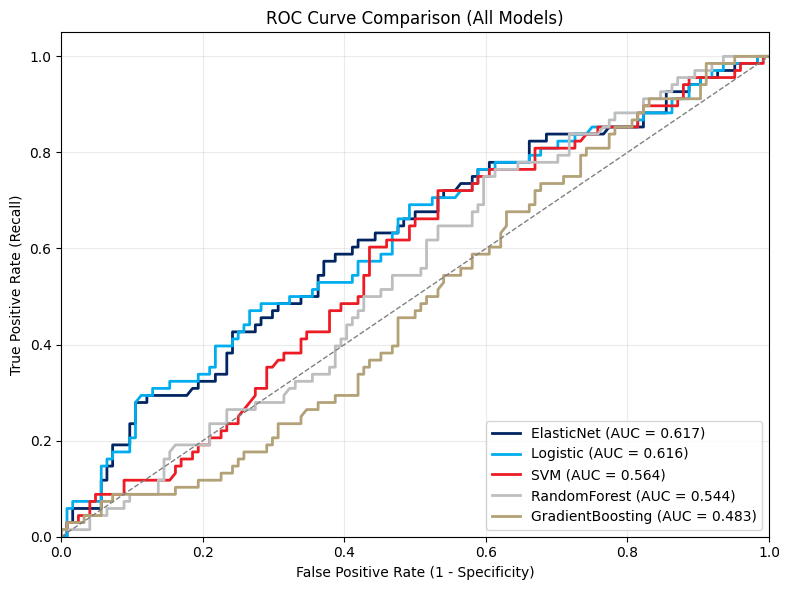

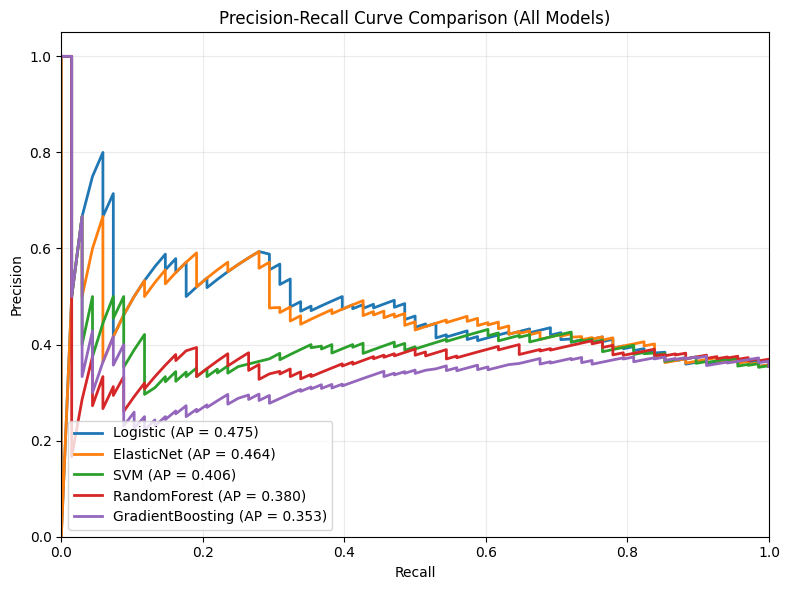

In [5]:
# === 0) 기본 세팅 ===
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score
)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# 선택형 모델들 (미설치 시 자동 건너뛰기)
has_xgb = True
has_lgbm = True
has_cat = True
try:
    from xgboost import XGBClassifier
except Exception:
    has_xgb = False
try:
    from lightgbm import LGBMClassifier
except Exception:
    has_lgbm = False
try:
    from catboost import CatBoostClassifier
except Exception:
    has_cat = False

# === 1) 데이터 로드 & 선택 컬럼 ===
df = pd.read_csv(r"C:\\Users\\NT551_11TH\\Documents\\Streak_Breaking_Solution\\data\\streak_binary_dataset.csv")

features = ["ISO", "DER", "KBB", "OBP", "OPS", "exp_minus_actual"]
target   = "target_streak"

# 숫자화 & inf -> NaN
for c in features:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)

X = df[features]
y = df[target].astype(int)

# === 2) Train/Test 분리 (층화) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("[INFO] NaN counts (train):")
print(pd.isna(X_train).sum())

# === 3) 모델 정의 ===
models = {
    "Logistic": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
    ]),
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=6, random_state=42, class_weight="balanced"
        ))
    ]),
    "SVM": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
        ))
    ]),
    "ElasticNet": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", SGDClassifier(
            loss="log_loss", penalty="elasticnet", alpha=1e-3, l1_ratio=0.5,
            max_iter=5000, class_weight="balanced", random_state=42
        ))
    ])
}

if has_xgb:
    models["XGBoost"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            use_label_encoder=False, eval_metric="logloss", random_state=42
        ))
    ])
if has_lgbm:
    models["LightGBM"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", LGBMClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=-1,
            class_weight="balanced", random_state=42
        ))
    ])
if has_cat:
    models["CatBoost"] = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", CatBoostClassifier(
            iterations=300, learning_rate=0.05, depth=4,
            loss_function="Logloss", eval_metric="AUC",
            verbose=False, random_state=42
        ))
    ])

# === 4) 전 모델 성능 비교 ===
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    # predict_proba 없을 때 대비(SGD 등): decision_function을 확률스케일로 정규화
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        scores = pipe.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        y_prob = (scores - smin) / (smax - smin + 1e-12)
    y_pred = (y_prob >= 0.5).astype(int)

    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc" : average_precision_score(y_test, y_prob),
        "report" : classification_report(y_test, y_pred, digits=4, output_dict=False)
    }

# === 5) 출력 (ROC-AUC/PR-AUC 정렬) ===
print("\n================ ALL MODELS (ROC-AUC / PR-AUC) ================")
for name, res in sorted(results.items(), key=lambda kv: kv[1]["roc_auc"], reverse=True):
    print(f"{name:16s} | ROC-AUC: {res['roc_auc']:.4f} | PR-AUC: {res['pr_auc']:.4f}")

# 필요 시 모델별 상세 리포트 출력
# for name, res in results.items():
#     print(f"\n=== {name} ===")
#     print(res["report"])

# === 4) 전 모델 성능 비교 ===
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    # predict_proba 없을 때 대비: decision_function 점수를 [0,1]로 정규화
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        scores = pipe.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        y_prob = (scores - smin) / (smax - smin + 1e-12)
    y_pred = (y_prob >= 0.5).astype(int)

    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc" : average_precision_score(y_test, y_prob),
        "report" : classification_report(y_test, y_pred, digits=4, output_dict=False),
        "y_prob" : y_prob  # ⬅ ROC/PR 곡선 그리기용으로 저장
    }

# === 5) 출력 (ROC-AUC/PR-AUC 정렬) ===
print("\n================ ALL MODELS (ROC-AUC / PR-AUC) ================")
for name, res in sorted(results.items(), key=lambda kv: kv[1]["roc_auc"], reverse=True):
    print(f"{name:16s} | ROC-AUC: {res['roc_auc']:.4f} | PR-AUC: {res['pr_auc']:.4f}")

# === 6) ROC 곡선 시각화 (커스텀 색상) ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 원하는 색상 팔레트 (모델 순서대로 매칭)
custom_colors = [
    "#002561",  # 진한 남색
    "#00AEEF",  # 하늘색
    "#ED1C24",  # 빨강
    "#BCBEC0",  # 회색
    "#B3A177"   # 갈색 톤
]

plt.figure(figsize=(8, 6))

# AUC 높은 순으로 정렬
sorted_results = sorted(results.items(), key=lambda kv: kv[1]["roc_auc"], reverse=True)

for (name, res), color in zip(sorted_results, custom_colors):
    y_prob = res["y_prob"]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})", color=color)

# 무작위 분류기 기준선
plt.plot([0, 1], [0, 1], "--", lw=1, color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison (All Models)")
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


# (옵션) PR 곡선도 보고 싶다면 아래 주석 해제
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(8, 6))
for name, res in sorted(results.items(), key=lambda kv: kv[1]["pr_auc"], reverse=True):
    y_prob = res["y_prob"]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, lw=2, label=f"{name} (AP = {ap:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison (All Models)")
plt.legend(loc="lower left", frameon=True)
plt.grid(alpha=0.25)
plt.tight_layout()
# plt.savefig("pr_curves_all_models.png", dpi=200)
plt.show()


In [43]:
# =========================
# Logistic/ElasticNet 튜닝 + 최적 threshold 찾기 (Youden / F1)
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix, f1_score
)

# -------- 0) 데이터 로드 --------
df = pd.read_csv(r"C:\Users\user\Documents\Streak-Breaking-Solution\Team_Statistics\streak_binary_dataset.csv")

features = ["ISO", "DER", "KBB", "OBP", "OPS", "exp_minus_actual"]
target   = "target_streak"

for c in features:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)

X = df[features]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("[INFO] NaN counts (train):")
print(pd.isna(X_train).sum())

# -------- 1) 파이프라인 & 그리드 --------
# - 서로 다른 penalty/solver 조합을 처리하기 위해 param_grid를 '리스트의 dict'로 구성
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

param_grid = [
    # (A) 순수 L2 (lbfgs)
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
        "clf__C": [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    },
    # (B) L1 또는 L2 (liblinear)
    {
        "clf__penalty": ["l1", "l2"],
        "clf__solver": ["liblinear"],
        "clf__C": [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    },
    # (C) ElasticNet (saga 전용)
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.15, 0.3, 0.5, 0.7, 0.85],
        "clf__C": [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",     # 주 스코어: ROC-AUC
    cv=cv,
    n_jobs=-1,
    refit=True,            # best_estimator_를 ROC-AUC 기준으로 재학습
    verbose=0
)

grid.fit(X_train, y_train)

print("\n=== GridSearchCV 결과 ===")
print("Best params :", grid.best_params_)
print("Best CV ROC-AUC :", round(grid.best_score_, 4))

best_model = grid.best_estimator_

# -------- 2) 테스트셋 성능(확률) --------
y_prob = best_model.predict_proba(X_test)[:, 1]
rocauc = roc_auc_score(y_test, y_prob)
prauc  = average_precision_score(y_test, y_prob)
print("\n=== Test 성능(확률기반) ===")
print("ROC-AUC:", round(rocauc, 4))
print("PR-AUC :", round(prauc, 4))

# -------- 3) 최적 threshold 탐색 (Youden / F1) --------
# 3-1) ROC 곡선 기반으로 Youden J = TPR - FPR 최대화
fpr, tpr, thr_roc = roc_curve(y_test, y_prob)
youden_idx = np.argmax(tpr - fpr)
thr_youden = thr_roc[youden_idx]

# 3-2) PR 곡선 기반 F1 최대화(또는 가능한 threshold 전 범위에서 F1 최대화)
prec, rec, thr_pr = precision_recall_curve(y_test, y_prob)
# precision_recall_curve는 마지막 점에서 threshold가 정의되지 않으니, 유효 threshold만 사용
thr_candidates = np.unique(np.concatenate([
    thr_roc,                               # ROC 기반 threshold 후보
    thr_pr[:-1],                           # PR 기반 threshold 후보(마지막 제외)
    np.linspace(0.05, 0.95, 19)            # 추가로 균일 샘플링
]))

def eval_at_threshold(t):
    y_hat = (y_prob >= t).astype(int)
    return {
        "thr": t,
        "f1": f1_score(y_test, y_hat, zero_division=0),
        "cm": confusion_matrix(y_test, y_hat)
    }

evaluated = [eval_at_threshold(t) for t in thr_candidates]
best_f1_item = max(evaluated, key=lambda d: d["f1"])
thr_f1 = best_f1_item["thr"]

# -------- 4) 각 threshold에서 최종 지표/리포트 --------
def report_threshold(name, thr):
    y_hat = (y_prob >= thr).astype(int)
    print(f"\n--- {name} 기준 threshold = {thr:.4f} ---")
    print(classification_report(y_test, y_hat, digits=4))
    cm = confusion_matrix(y_test, y_hat)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:\n", cm)
    # 추가로, 민감도/특이도/정밀도/재현율/정확도 출력
    sens = tp / (tp + fn + 1e-12)
    spec = tn / (tn + fp + 1e-12)
    prec_ = tp / (tp + fp + 1e-12)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    print(f"Sensitivity(Recall): {sens:.4f}, Specificity: {spec:.4f}, Precision: {prec_:.4f}, Accuracy: {acc:.4f}")

report_threshold("Youden(J=TPR-FPR) 최적", thr_youden)
report_threshold("F1 최적", thr_f1)

# 참고: 운영 목적에 따라 임계값을 의도적으로 낮추거나(Recall↑) 높일 수 있습니다.
print("\n[요약] 최적 threshold")
print(f"- Youden 기준: {thr_youden:.4f}")
print(f"- F1    기준: {thr_f1:.4f}")


[INFO] NaN counts (train):
ISO                  0
DER                  0
KBB                 39
OBP                  0
OPS                  0
exp_minus_actual     0
dtype: int64

=== GridSearchCV 결과 ===
Best params : {'clf__C': 2, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best CV ROC-AUC : 0.7118

=== Test 성능(확률기반) ===
ROC-AUC: 0.6157
PR-AUC : 0.4759

--- Youden(J=TPR-FPR) 최적 기준 threshold = 0.6092 ---
              precision    recall  f1-score   support

           0     0.7121    0.7581    0.7344       124
           1     0.5000    0.4412    0.4688        68

    accuracy                         0.6458       192
   macro avg     0.6061    0.5996    0.6016       192
weighted avg     0.6370    0.6458    0.6403       192

Confusion Matrix:
 [[94 30]
 [38 30]]
Sensitivity(Recall): 0.4412, Specificity: 0.7581, Precision: 0.5000, Accuracy: 0.6458

--- F1 최적 기준 threshold = 0.3819 ---
              precision    recall  f1-score   support

           0     0.7619    0.3871    0.5134 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17664\1894590791.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_test_imp_df, feature_names=features, show=False)


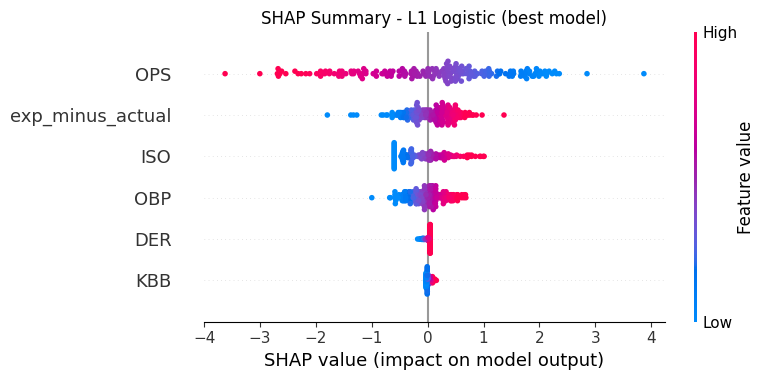

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_17664\1894590791.py:46: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_test_imp_df, feature_names=features, plot_type="bar", show=False)


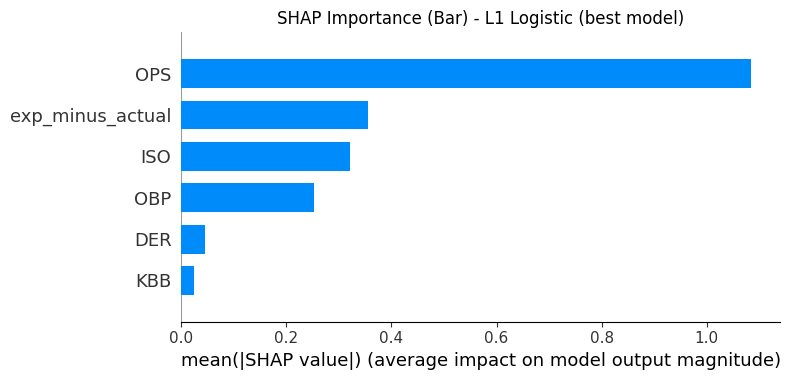


[SHAP Mean |value| Ranking]  (L1 Logistic)
OPS                1.085005
exp_minus_actual   0.356221
ISO                0.321221
OBP                0.251845
DER                0.045305
KBB                0.023887

[Coefficients vs Mean |SHAP|]  (값이 +이면 연패 확률 ↑, -이면 ↓ 경향)
                      coef  mean_|SHAP|
OPS              -1.322431     1.085005
ISO               0.440319     0.321221
exp_minus_actual  0.397368     0.356221
OBP               0.294389     0.251845
DER               0.053809     0.045305
KBB               0.036786     0.023887


In [44]:
# ===== SHAP for tuned L1-Logistic =====
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 파이프라인 단계 추출
best_pipe = best_model            # GridSearchCV의 best_estimator_
imputer   = best_pipe.named_steps["imputer"]
scaler    = best_pipe.named_steps["scaler"]
lin_clf   = best_pipe.named_steps["clf"]   # L1 Logistic (liblinear)

# 2) 같은 변환으로 Train/Test 변환
X_train_imp = imputer.transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_tr  = scaler.transform(X_train_imp)  # 모델이 보는 공간
X_test_tr   = scaler.transform(X_test_imp)

# 3) LinearExplainer로 SHAP 계산 (SHAP 0.48 호환)
#    배경데이터(background)로 X_train_tr를 주는 것이 안정적
explainer = shap.LinearExplainer(lin_clf, X_train_tr)
sv = explainer.shap_values(X_test_tr)   # (n_samples, n_features) 기대

# 4) 모양 안전검사 (간혹 3D나 +1열 문제 방어)
if isinstance(sv, list):
    # 이진분류인데 리스트로 나오는 케이스 방어(보통 양성 클래스=1 사용)
    sv = sv[1] if len(sv) == 2 else sv[0]
sv = np.asarray(sv)
if sv.ndim == 3:
    sv = sv[:, :, 1 if sv.shape[2] >= 2 else 0]
if sv.shape[1] == X_test_imp.shape[1] + 1:
    sv = sv[:, :-1]

assert sv.shape[1] == X_test_imp.shape[1] == len(features), \
    f"SHAP cols {sv.shape[1]} != features {X_test_imp.shape[1]}"

# 5) 시각화: 요약 플롯(색=원본 값), 바 플롯(평균 |SHAP|)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=features, index=X_test.index)

plt.title("SHAP Summary - L1 Logistic (best model)")
shap.summary_plot(sv, X_test_imp_df, feature_names=features, show=False)
plt.show()

plt.title("SHAP Importance (Bar) - L1 Logistic (best model)")
shap.summary_plot(sv, X_test_imp_df, feature_names=features, plot_type="bar", show=False)
plt.show()

# 6) 텍스트 랭킹 (평균 |SHAP|)
abs_mean = np.abs(sv).mean(axis=0)
fi_table = pd.Series(abs_mean, index=features).sort_values(ascending=False)
print("\n[SHAP Mean |value| Ranking]  (L1 Logistic)")
print(fi_table.to_string(float_format=lambda x: f"{x:.6f}"))

# 7) 보너스: 계수(sign)와 함께 표로 비교 (방향 해석에 도움)
coef = pd.Series(lin_clf.coef_.ravel(), index=features).sort_values(key=np.abs, ascending=False)
coef_df = pd.DataFrame({
    "coef": coef,
    "mean_|SHAP|": fi_table.reindex(coef.index)
})
print("\n[Coefficients vs Mean |SHAP|]  (값이 +이면 연패 확률 ↑, -이면 ↓ 경향)")
print(coef_df.to_string(float_format=lambda x: f"{x:.6f}"))


In [45]:
# 학습 끝난 코드 제일 아래에 추가
import joblib
joblib.dump(best_model, "logistic_streak_model.pkl")


['logistic_streak_model.pkl']